# Run W2V usecase

In [1]:
#https://kb.oakland.edu/uts/HPCJupyterMPI
import ipyparallel as ipp

In [2]:
def mpi_code():
    from mpi4py import MPI
    import tensair_py
    import math
    comm = MPI.COMM_WORLD
    
    tensair_path = os.environ.get("TENSAIR_PATH")

    mini_batch_size = 2048
    msg_sec = 200 
    train_data_file = tensair_path + "/data/w2v/shakespeare_train.txt" #Created using W2V_data notebook
    event_generator = tensair_py.W2V_EventGenerator(mpi_comm=comm, tag=1, mini_batch_size=mini_batch_size, msg_sec=msg_sec, train_data_file=train_data_file)
    
    inputMaxSize = 4+4+ (8*3) + (4*mini_batch_size) + (4*mini_batch_size*5) + (4*mini_batch_size*5)
    gradientsMaxSize = 8+4+4+4+(8*4) + 4 + 4 + (4*50000*300*2)
    window_size = max(inputMaxSize, gradientsMaxSize)
    saved_model_dir = tensair_path + "/data/w2v/w2v_model.tf" #Created using W2V-Model notebook
    drift_detector_mode = 1
    dataset_size = 112640 #shakespeare dataset size
    epoch_size= math.floor(dataset_size/mini_batch_size)
    model = tensair_py.TensAIR(mpi_comm=comm, tag=2, window_size=window_size, saved_model_dir=saved_model_dir, 
                               drift_detector_mode=drift_detector_mode,epoch_size=epoch_size)

    operators = [event_generator, model]
    links = [[0,1],[1,1]]
    basic_dataflow = tensair_py.BasicDataflow(mpi_comm=comm, operators=operators, links=links)
    print("Starting dataflow")
    basic_dataflow.streamProcess()


In [3]:
rc = ipp.Cluster(controller_ip="*", engines="mpi", n=2).start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

In [4]:
view = rc.broadcast_view()

In [5]:
ar_list = [view.apply_async(mpi_code, 2)]

In [6]:
asyn_run = view.apply_async(mpi_code)

In [7]:
asyn_run

<AsyncResult(mpi_code): pending>

# Visualize Results

The visualization does not work on jupyter lab, only on upyter notebook

In [8]:
%matplotlib ipympl
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import os

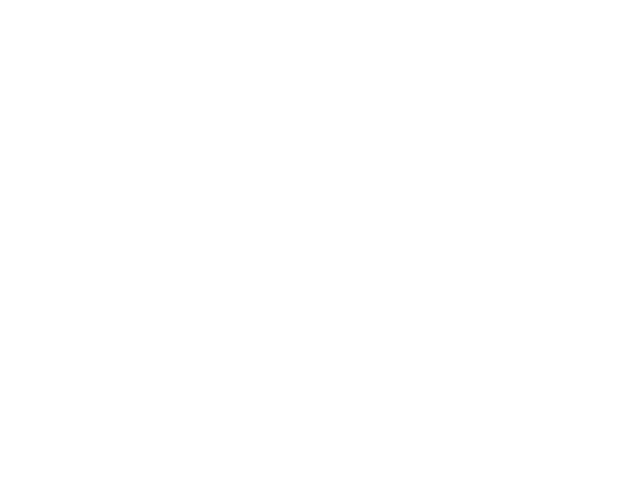

In [9]:
index = count()
losses = []
accs = []
conditions = []
conditions_first = {'blue': True, 'red': True}
wainting_file = True

tensair_path = os.environ.get("TENSAIR_PATH")
outputfile = tensair_path + "/output/0.csv"


while(wainting_file):
    try: 
        myfile = open(outputfile, "r")
        wainting_file = False
    except:
        time.sleep(1)
    
def animate(i):
    global losses, conditions
    while True:
        line = myfile.readline()
        if line != "":
            parts = line.split(',')
            losses.append(float(parts[2]))
            conditions.append(parts[0])  # Assume this is the condition
        else:
            break

    plt.cla()  # Clear the axes to avoid drawing over the old lines

    # Plot each segment with a color based on the condition
    for j in range(1, len(losses)):
        color = 'blue' if conditions[j] == 'training' else 'red'
        if conditions_first[color]:
            plt.plot([j-1, j], [losses[j-1], losses[j]], color=color, label=conditions[j])
            conditions_first[color] = False
        else:
            plt.plot([j-1, j], [losses[j-1], losses[j]], color=color)
            
    plt.xlabel('datastream')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', shadow=True, fontsize='large')

            
ani = FuncAnimation(plt.gcf(), animate, interval=1000)

plt.show()

In [10]:
ani.pause()